# Demonstation notebook

Graph theoretical tools using thermodynamic formalism to detect & understand allosteric pathways

Steps...
1) BagPype to generate protein network
2) Identify poteinial paths with Flow Path - Maximum flow algorithm and A* path search
3) Evaluate the flow paths using Path Rank - Ruelle-Bowen random walk probability and quantile regression
4) Compute most functionally important allosteric signalling residues, compare with experimental data

## Imports

In [1]:
# Standard library imports
import matplotlib.pyplot as plt
import numpy as np
import os

# Specialised functions
import bagpype as bgp

import flowpathrank


 |‾|                Welcome to              
 | |__   __ _  __ _ _ __  _   _ _ __   ___  
 | '_ \ / _` |/ _` | '_ \| | | | '_ \ / _ \ 
 | |_) | (_| | (_| | |_) | |_| | |_) |  __/ 
 |_.__/ \__,_|\__, | .__/ \__, | .__/ \___| 
               __/ | |     __/ | |          
              |___/|_|    |___/|_|          
Biochemical, Atomistic Graph construction   
software in PYthon for Proteins, Etc.       
(C) Yaliraki group @ Imperial College London

Flow Path (residue level) ...
Path Rank...
Extra tools...


## Setup

In [2]:
# For BagPype
# Name and PDB code of protein you want to analyse
prot_name = 'caspase-1' # this is the name of the directory
pdbcode   = '2hbq'

base_dir    = os.getcwd()
working_dir = base_dir + f'\\{prot_name}\\'

# Move into relevant directory
os.chdir(working_dir)

In [3]:
# Site residues
# residues in active & allosteric sites, format 'XYZ12 A'
act_site  = ['PRO177 A', 'ARG179 A', 'GLY238 A', 'GLN283 A', 'CYS285 A', 'VAL338 B', 'SER339 B', 'TRP340 B', 'ARG341 B', 'HIS342 B', 'ARG383 B', 'PHQ1 C', 'CF05 C']
allo_site = ['ARG286 A', 'ALA329 B', 'CYS331 B', 'PRO335 B', 'THR388 B']
# Residues considered are those around active site / with interactions with allosteric binding ligand

## Graph Generation: BagPype

In [4]:
# Run BagPype to generate energy-weighted atomistic graph of protein

# generate graph
myprot = bgp.molecules.Protein()

parser = bgp.parsing.PDBParser(f'./pdb_dir/{pdbcode}_modified.pdb', download=False)
parser.parse(myprot, strip = {'res_name': ['HOH']}, MakeMultimer_number=None)

ggenerator = bgp.construction.Graph_constructor()
ggenerator.construct_graph(myprot)

# *** IMPORTANT: REDUCE no longer works on Windows
# --> if using a Windows device please use ProteinLens.io first to generate PDB file with hydrogen atoms added

Stripping unwanted atom types from the PDB file ['HOH', 'UNK', 'UNL', 'UNX']
Loading atoms into protein object from file: ./pdb_dir/2hbq_modified_stripped.pdb

Graph construction started
Initialising all possible bonds, memory efficiently...
Initialising covalent bond energies for ALA, ARG, ASN, ASP, CF0, CYS, GLN, GLU, GLY, HIS, ILE, LEU, LYS, MET, PHE, PHQ, PRO, SER, THR, TRP, TYR, VAL
Processing LINK entries...
Finding covalent bonds...
    Considering covalent LINK entries...
Finding hydrogen bonds at cutoff = -0.01kcal/mol...
    Assigning H-bond status...
    Applying constraints and computing bond strengths...
    Total energy of hydrogen bonds and salt bridges: -999.74 kcal/mol
Finding hydrophobics...


C:\Users\ralph\anaconda3\envs\env_bagpype\lib\site-packages\bagpype\construction.py:1453: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  D = nx.adjacency_matrix(graph, weight="energy", nodelist=node_list).todense()


    RMST sparsification used. Accepted: 463, rejected: 9440; MST size: 609
    Total energy of hydrophobic effect: -443.32 kcal/mol
Finding stacked interactions in DNA...
Finding DNA backbone interactions...
Finding electrostatic interactions using LINK entries...
Finished constructing the graph! #residues = 261, #atoms = 4081, #bonds = 5545
    Time taken = 2.97s, final filename: ./pdb_dir/2hbq_modified_stripped.pdb



## Flow Path & Path Rank

In [5]:
# Run Flow Path and Path Rank through all source-target combinations specified
paths_dict = flowpathrank.analyse_prot(myprot, pdbcode, act_site, allo_site, is_logged=True)

# Run Quantile Regression on Path Rank probabilities by path length
stat_reduced = flowpathrank.statistical_reduction(paths_dict)

# Save data to csv
flowpathrank.save_paths_to_csv(stat_reduced.scored_paths_dict)

Checking Adjacency matrix, B
Symmetric:    True
Non-negative: True

Roulle-Bowen random walk... Checking eigenvalues and eigenvectors...
Is eigenvalue calculated same for left & right:         True , 4.331743391711414 # trivial
Is sum of entries in left eigenvector unity:            True , 1.0
Is sum of product of left and right eigenvectors unity: True , 0.9999999999999999
No imaginary parts:                                     True , 0.0

Running Flow Path for source residue PRO177 A...
Running Flow Path for source residue ARG179 A...
Running Flow Path for source residue GLY238 A...
Running Flow Path for source residue GLN283 A...
Running Flow Path for source residue CYS285 A...
Running Flow Path for source residue VAL338 B...
Running Flow Path for source residue SER339 B...
Running Flow Path for source residue TRP340 B...
Running Flow Path for source residue ARG341 B...
Running Flow Path for source residue HIS342 B...
Running Flow Path for source residue ARG383 B...
Running Flow Pat

Above quantile 0.75 #paths=15.0


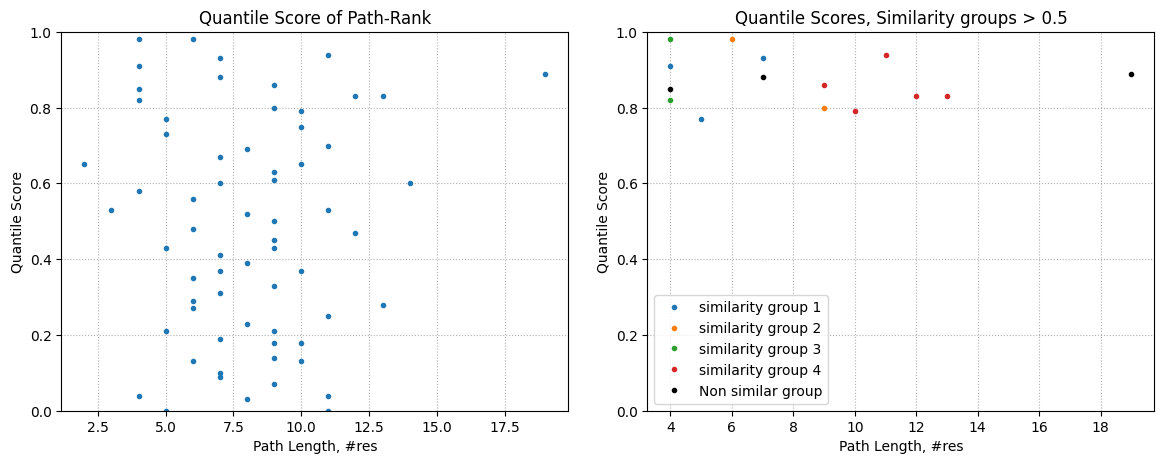

Grouped paths (source & target) by similarity 0.5


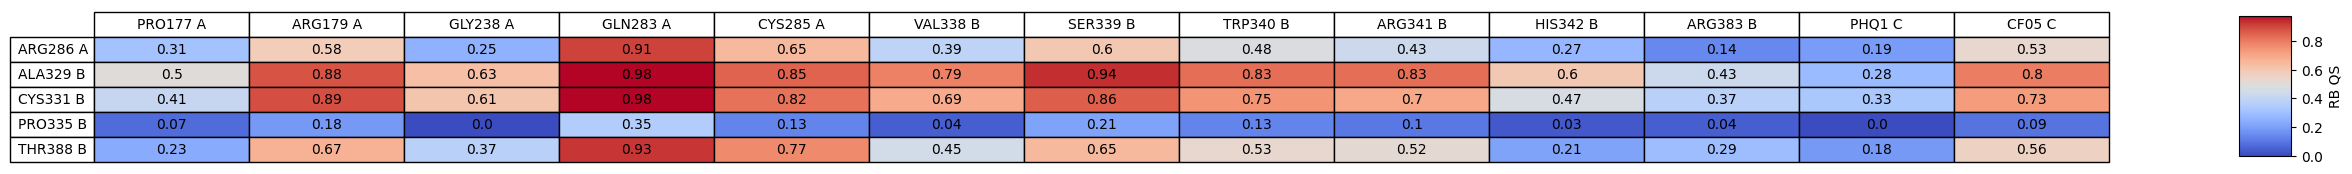

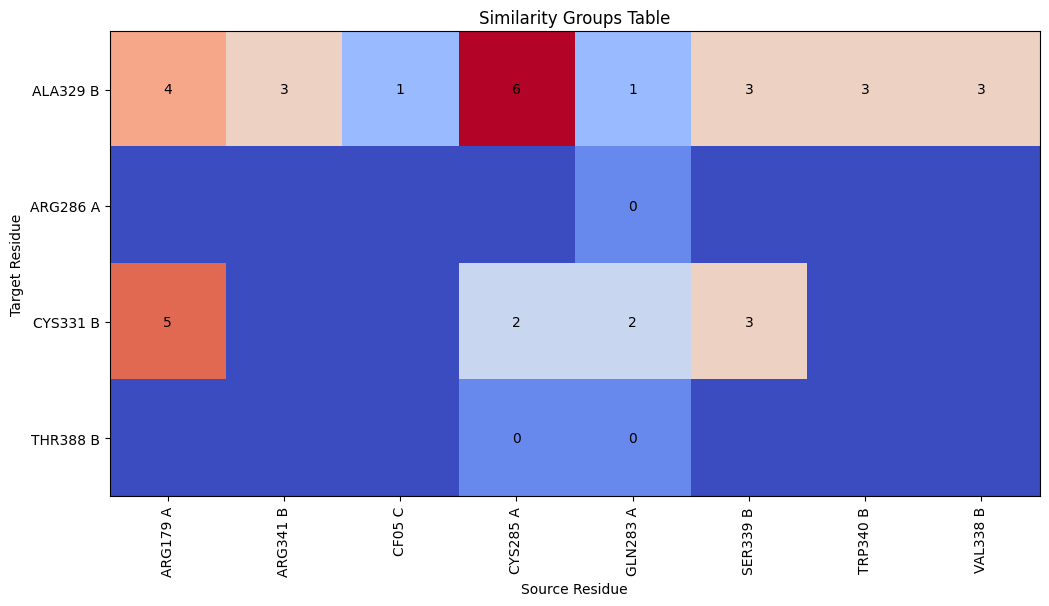

In [6]:
# Additional visualisations of Flow Path & Path Rank data -> Quantile Scores, Similarity groupings
stat_reduced.visuals_out()
# Optional!

## Conservation Scores

In [7]:
# Compare computational results with experimental data, comparing...
# 1) Highest weighted frequency residues (in flow paths, weighted by Path Rank quantile scores) 
# 2) Evolutionary conservation scores (from ConSurf database)
conserv = flowpathrank.conservation_analysis(myprot)
conserv.find_func_res_conservation(stat_reduced.scored_paths_dict)
# Computationally predicted top 10 residues below, with associated ConSurf scores

,raw freq,weighted freq,consurf
ASP4 C,15,6.13,NaN
SER332 B,10,5.32,"[-0.997, -0.913]"
GLU390 B,7,4.10,"[-0.779, -0.611]"
ARG286 A,7,4.10,"[-1.279, -1.177]"
ARG179 A,9,3.83,"[-1.279, -1.177]"
ALA284 A,6,3.30,"[-1.247, -1.138]"
CYS331 B,8,3.07,"[-0.004, 0.371]"
THR388 B,8,3.07,"[-0.657, -0.511]"
ILE328 B,4,2.69,"[-0.74, -0.563]"
ILE280 A,4,2.69,"[-1.177, -1.056]"
